# M33 Calibration — Baryonic Omega Analysis

**Goal:** Validate the pipeline by replicating Corbelli's M33 mass model results.

**Success Criterion:** V_bary agrees with Corbelli's published V_stars + V_gas within 5% at R > 2 kpc.

**Key Question:** Does omega stabilize the rotation curve without a dark matter halo?

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.database import init_db, get_session, query_profiles_as_dataframe, Galaxy
from src.ingest import ingest_m33
from src.physics import compute_v_bary, fit_omega
from src.fit import generate_decomposition_plot

sns.set_theme(style='whitegrid', font_scale=1.1)
%matplotlib inline

## 1. Data Acquisition

M33 is not in the SPARC catalog. We use Corbelli et al. (2014) Table 1 data,
extracted from the paper into `data/extracted/corbelli2014_table1.csv`.

This table provides:
- **Rotation curve:** $V_r(R)$ and $\sigma_V(R)$ — 57 radial bins from 0.24 to 22.72 kpc
- **Surface densities:** $\Sigma_{HI}(R)$ and $\Sigma_*(R)$ in $M_\odot/\text{pc}^2$

Since the table provides surface densities (not velocity components like SPARC),
we convert $\Sigma \to V_{circ}$ using the **Casertano (1983) thin-disk method**:
the disk is modeled as concentric rings and the gravitational potential is computed
via complete elliptic integrals (Binney & Tremaine 2008, Eq. 2.188).

**Key parameters (Corbelli 2014):** D = 0.84 Mpc, i = 52°

In [2]:
# Ingest M33 — uses Corbelli 2014 Table 1 by default (no network needed)
galaxy_id = ingest_m33()
print(f'Ingested as: {galaxy_id}')

# Check data source
engine = init_db()
session = get_session(engine)
galaxy = session.get(Galaxy, 'M33')
print(f'Data source: {galaxy.data_source}')
print(f'Distance: {galaxy.distance_mpc} Mpc')
print(f'Inclination: {galaxy.inclination}°')
M33_AVAILABLE = True

2026-02-22 17:51:25 | INFO     | src.ingest | Loaded Corbelli 2014 Table 1: 58 data points (R = 0.24 – 22.72 kpc)
2026-02-22 17:51:27 | INFO     | src.ingest | Computed velocity components: V_gas peak=38.0 km/s, V_disk peak=62.2 km/s
2026-02-22 17:51:27 | INFO     | src.database | Database initialized at C:\Projects\ISM\baryonic-omega-analysis\data\processed\galaxy_dynamics.db
2026-02-22 17:51:27 | INFO     | src.database | Upserted galaxy: M33
2026-02-22 17:51:27 | INFO     | src.database | Inserted 58 radial profiles for M33
2026-02-22 17:51:27 | INFO     | src.ingest | Ingested M33: 58 profiles from Corbelli2014_Table1 (Upsilon_d=0.50, Upsilon_b=0.70)
2026-02-22 17:51:27 | INFO     | src.database | Database initialized at C:\Projects\ISM\baryonic-omega-analysis\data\processed\galaxy_dynamics.db


Ingested as: M33
Data source: Corbelli2014_Table1
Distance: 0.84 Mpc
Inclination: 52.0°


2026-02-22 17:51:27 | INFO     | src.ingest | Loaded Corbelli 2014 Table 1: 58 data points (R = 0.24 – 22.72 kpc)
2026-02-22 17:51:29 | INFO     | src.ingest | Computed velocity components: V_gas peak=38.0 km/s, V_disk peak=62.2 km/s


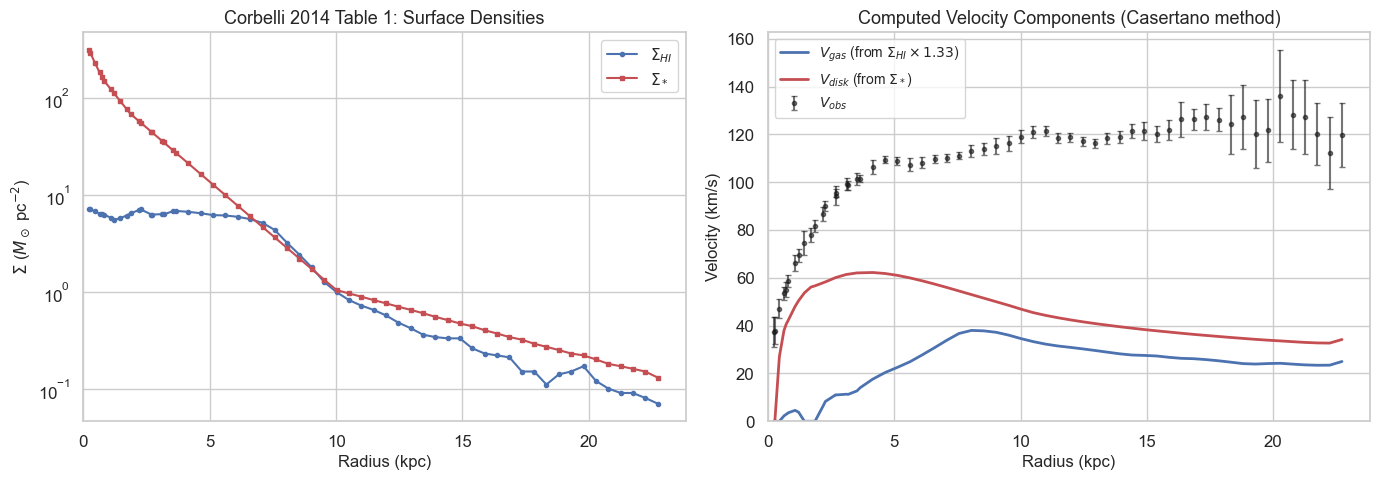

V_gas peak: 38.0 km/s
V_disk peak: 62.2 km/s


In [3]:
# Visualize the raw Corbelli 2014 data and computed velocity components
from src.ingest import load_m33_corbelli2014_data

raw_c14 = pd.read_csv('../data/extracted/corbelli2014_table1.csv', comment='#')
sparc_df = load_m33_corbelli2014_data()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Surface density profiles
ax1.semilogy(raw_c14['R_kpc'], raw_c14['Sigma_HI_Msun_pc2'], 'b-o', markersize=3, label=r'$\Sigma_{HI}$')
ax1.semilogy(raw_c14['R_kpc'], raw_c14['Sigma_star_Msun_pc2'], 'r-s', markersize=3, label=r'$\Sigma_*$')
ax1.set_xlabel('Radius (kpc)', fontsize=12)
ax1.set_ylabel(r'$\Sigma$ ($M_\odot$ pc$^{-2}$)', fontsize=12)
ax1.set_title('Corbelli 2014 Table 1: Surface Densities', fontsize=13)
ax1.legend(fontsize=11)
ax1.set_xlim(left=0)

# Right: Computed velocity components
ax2.plot(sparc_df['Rad'], sparc_df['Vgas'], 'b-', linewidth=2, label=r'$V_{gas}$ (from $\Sigma_{HI} \times 1.33$)')
ax2.plot(sparc_df['Rad'], sparc_df['Vdisk'], 'r-', linewidth=2, label=r'$V_{disk}$ (from $\Sigma_*$)')
ax2.errorbar(sparc_df['Rad'], sparc_df['Vobs'], yerr=sparc_df['errV'],
             fmt='ko', markersize=3, capsize=2, alpha=0.6, label=r'$V_{obs}$')
ax2.set_xlabel('Radius (kpc)', fontsize=12)
ax2.set_ylabel('Velocity (km/s)', fontsize=12)
ax2.set_title('Computed Velocity Components (Casertano method)', fontsize=13)
ax2.legend(fontsize=10)
ax2.set_xlim(left=0)
ax2.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

print(f'V_gas peak: {sparc_df["Vgas"].max():.1f} km/s')
print(f'V_disk peak: {sparc_df["Vdisk"].max():.1f} km/s')

## 2. Ingest M33 Data

In [4]:
# Query profiles from database
df = query_profiles_as_dataframe(session, 'M33')
print(f'Profiles retrieved: {len(df)}')
print(f'Radius range: {df["radius_kpc"].min():.1f} — {df["radius_kpc"].max():.1f} kpc')
display(df.head(10))

Profiles retrieved: 58
Radius range: 0.2 — 22.7 kpc


,radius_kpc,v_obs,v_err,v_gas,v_disk,v_bulge,v_baryon_total
0,0.24,37.3,6.2,0.000000,0.000000,0.0,0.000000
1,0.28,37.9,5.5,0.000000,0.000000,0.0,0.000000
2,0.46,47.1,3.9,0.000000,27.053590,0.0,19.129777
3,0.64,53.5,2.8,2.231145,37.894227,0.0,26.887994
4,0.73,55.1,3.3,2.909610,40.625337,0.0,28.873428
5,0.82,58.5,2.5,3.580612,42.443850,0.0,30.225172
6,1.08,66.2,3.3,4.560130,48.002083,0.0,34.247551
7,1.22,69.4,2.8,3.797043,50.427262,0.0,35.859056
8,1.45,74.6,5.0,0.000000,53.709808,0.0,37.978569
9,1.71,77.9,2.9,0.000000,56.135976,0.0,39.694129


## 3. Inspect Profiles from Database

In [5]:
# Summary statistics
display(df.describe())

,radius_kpc,v_obs,v_err,v_gas,v_disk,v_bulge,v_baryon_total
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.0,58.000000
mean,9.619310,104.368966,4.931034,20.684317,44.653130,0.0,39.312839
std,7.179545,24.632500,4.539581,11.850398,13.491908,0.0,10.422219
min,0.240000,37.300000,1.300000,0.000000,0.000000,0.0,0.000000
25%,2.805000,96.225000,2.250000,11.121382,35.994885,0.0,34.472663
50%,8.795000,113.450000,2.850000,24.191411,42.872986,0.0,39.884001
75%,15.757500,120.825000,4.925000,28.724536,56.520129,0.0,45.991555
max,22.720000,136.000000,19.100000,37.999471,62.218857,0.0,53.363757


## 4. Compute V_bary and Compare to Corbelli

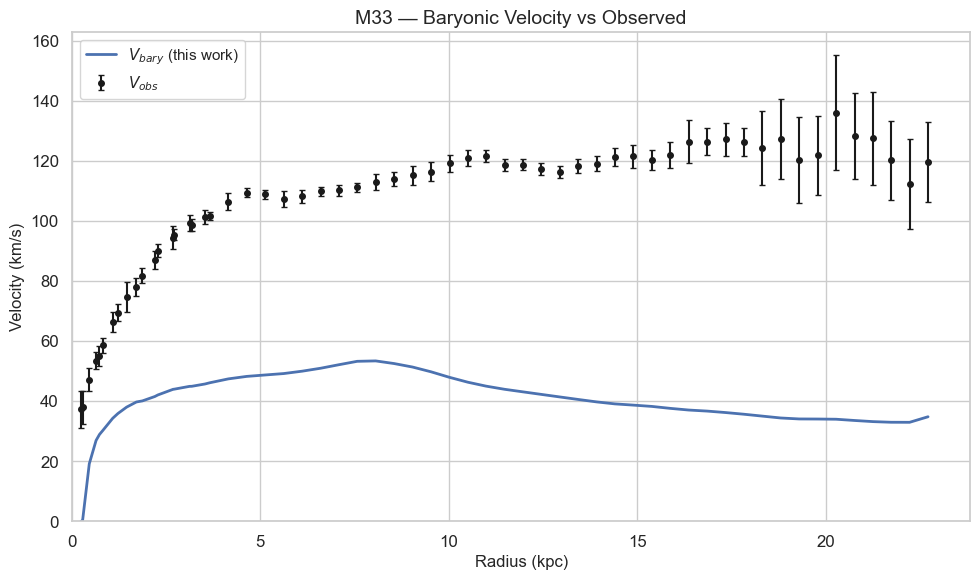


Velocity deficit (V_obs - V_bary) at R > 2 kpc:
  Mean: 72.5 km/s
  Range: [45.3, 102.0] km/s


In [6]:
UPSILON_DISK = 0.5
UPSILON_BULGE = 0.7

v_bary = compute_v_bary(
    df['v_gas'].values,
    df['v_disk'].values,
    df['v_bulge'].values,
    upsilon_disk=UPSILON_DISK,
    upsilon_bulge=UPSILON_BULGE,
)

fig, ax = plt.subplots(figsize=(10, 6))
radius = df['radius_kpc'].values

ax.errorbar(radius, df['v_obs'].values, yerr=df['v_err'].values,
            fmt='ko', markersize=4, capsize=2, label=r'$V_{obs}$')
ax.plot(radius, v_bary, 'b-', linewidth=2, label=r'$V_{bary}$ (this work)')

ax.set_xlabel('Radius (kpc)', fontsize=12)
ax.set_ylabel('Velocity (km/s)', fontsize=12)
ax.set_title('M33 — Baryonic Velocity vs Observed', fontsize=14)
ax.legend(fontsize=11)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
plt.tight_layout()
plt.show()

# Quantify the gap (this is what omega should fill)
mask = radius > 2.0
deficit = df['v_obs'].values[mask] - v_bary[mask]
print(f'\nVelocity deficit (V_obs - V_bary) at R > 2 kpc:')
print(f'  Mean: {np.mean(deficit):.1f} km/s')
print(f'  Range: [{np.min(deficit):.1f}, {np.max(deficit):.1f}] km/s')

## 5. Fit Omega

In [7]:
result = fit_omega(
    radius,
    df['v_obs'].values,
    df['v_err'].values,
    v_bary,
    galaxy_id='M33',
    upsilon_disk=UPSILON_DISK,
    upsilon_bulge=UPSILON_BULGE,
)

print(f'Omega: {result.omega_value:.4f} +/- {result.omega_uncertainty:.4f} km/s/kpc')
print(f'Chi-squared (reduced): {result.reduced_chi_squared:.2f}')
print(f'RMSE: {result.residuals_rmse:.2f} km/s')
print(f'Converged: {result.converged}')
print(f'V_obs < V_bary flag: {result.flag_v_obs_lt_v_bary}')

2026-02-22 17:51:30 | INFO     | src.physics | M33: omega=6.9749 +/- 0.0418 km/s/kpc  chi2_r=72.91  RMSE=31.05 km/s


Omega: 6.9749 +/- 0.0418 km/s/kpc
Chi-squared (reduced): 72.91
RMSE: 31.05 km/s
Converged: True
V_obs < V_bary flag: False


## 6. Decomposition Plot

2026-02-22 17:51:30 | INFO     | src.fit | Plot saved: ../results/figures/M33_decomposition.png


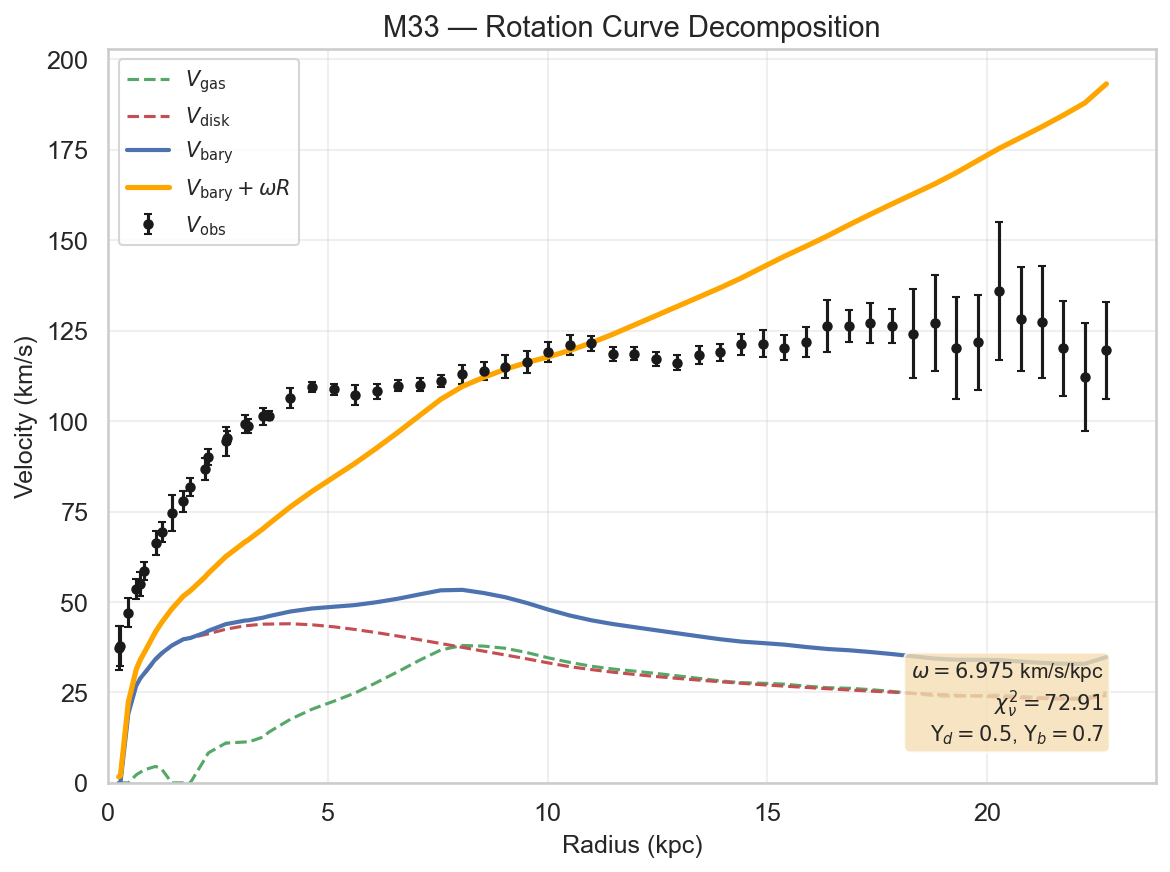

In [8]:
generate_decomposition_plot(
    galaxy_id='M33',
    radius=radius,
    v_obs=df['v_obs'].values,
    v_err=df['v_err'].values,
    v_gas=df['v_gas'].values,
    v_disk=df['v_disk'].values,
    v_bulge=df['v_bulge'].values,
    v_bary=v_bary,
    v_model=result.v_model,
    omega_value=result.omega_value,
    chi_squared=result.reduced_chi_squared,
    upsilon_disk=UPSILON_DISK,
    upsilon_bulge=UPSILON_BULGE,
    output_path='../results/figures/M33_decomposition.png',
)

# Also display inline
from IPython.display import Image
Image('../results/figures/M33_decomposition.png')

## 7. Sensitivity Analysis: Omega vs Upsilon_disk

2026-02-22 17:51:30 | INFO     | src.physics | M33: omega=7.5521 +/- 0.0418 km/s/kpc  chi2_r=110.49  RMSE=36.68 km/s
2026-02-22 17:51:30 | INFO     | src.physics | M33: omega=7.3993 +/- 0.0418 km/s/kpc  chi2_r=99.43  RMSE=35.15 km/s
2026-02-22 17:51:30 | INFO     | src.physics | M33: omega=7.2527 +/- 0.0418 km/s/kpc  chi2_r=89.60  RMSE=33.71 km/s
2026-02-22 17:51:30 | INFO     | src.physics | M33: omega=7.1114 +/- 0.0418 km/s/kpc  chi2_r=80.82  RMSE=32.35 km/s
2026-02-22 17:51:30 | INFO     | src.physics | M33: omega=6.9749 +/- 0.0418 km/s/kpc  chi2_r=72.91  RMSE=31.05 km/s
2026-02-22 17:51:30 | INFO     | src.physics | M33: omega=6.8426 +/- 0.0418 km/s/kpc  chi2_r=65.76  RMSE=29.82 km/s
2026-02-22 17:51:30 | INFO     | src.physics | M33: omega=6.7142 +/- 0.0418 km/s/kpc  chi2_r=59.27  RMSE=28.63 km/s
2026-02-22 17:51:30 | INFO     | src.physics | M33: omega=6.5894 +/- 0.0418 km/s/kpc  chi2_r=53.36  RMSE=27.49 km/s
2026-02-22 17:51:30 | INFO     | src.physics | M33: omega=6.4678 +/- 0.

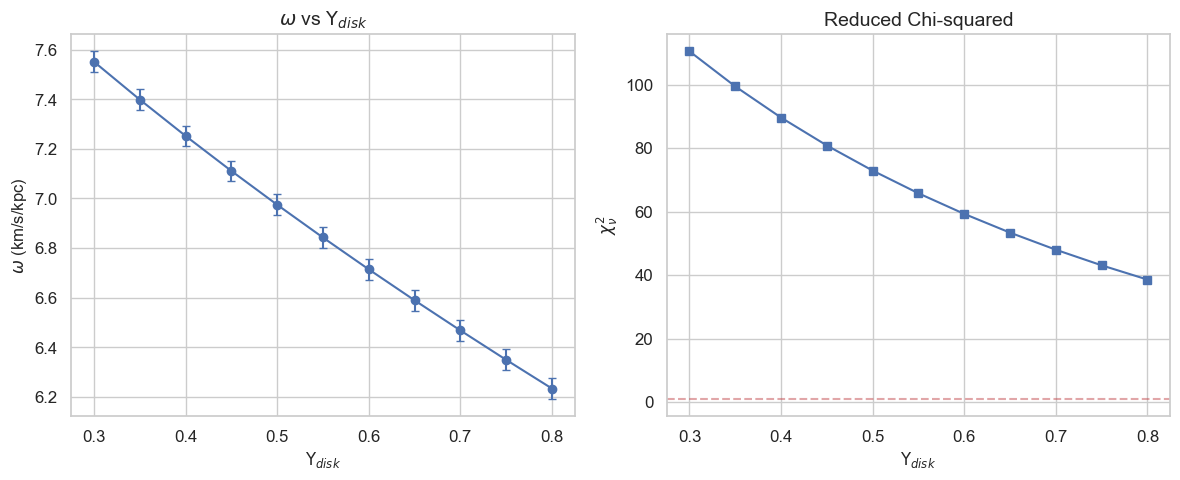

,upsilon_disk,omega,omega_err,chi2_r
0,0.30,7.5521,0.0418,110.4908
1,0.35,7.3993,0.0418,99.4259
2,0.40,7.2527,0.0418,89.6041
3,0.45,7.1114,0.0418,80.8166
4,0.50,6.9749,0.0418,72.9072
5,0.55,6.8426,0.0418,65.7553
6,0.60,6.7142,0.0418,59.2654
7,0.65,6.5894,0.0418,53.3605
8,0.70,6.4678,0.0418,47.9775
9,0.75,6.3491,0.0418,43.0638


In [9]:
upsilon_values = np.arange(0.3, 0.85, 0.05)
omega_results = []

for ud in upsilon_values:
    vb = compute_v_bary(
        df['v_gas'].values, df['v_disk'].values, df['v_bulge'].values,
        upsilon_disk=ud, upsilon_bulge=UPSILON_BULGE,
    )
    r = fit_omega(radius, df['v_obs'].values, df['v_err'].values, vb,
                  galaxy_id='M33', upsilon_disk=ud)
    omega_results.append({
        'upsilon_disk': ud,
        'omega': r.omega_value,
        'omega_err': r.omega_uncertainty,
        'chi2_r': r.reduced_chi_squared,
    })

sens_df = pd.DataFrame(omega_results)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.errorbar(sens_df['upsilon_disk'], sens_df['omega'],
             yerr=sens_df['omega_err'], fmt='o-', capsize=3)
ax1.set_xlabel(r'$\Upsilon_{disk}$', fontsize=12)
ax1.set_ylabel(r'$\omega$ (km/s/kpc)', fontsize=12)
ax1.set_title(r'$\omega$ vs $\Upsilon_{disk}$', fontsize=14)

ax2.plot(sens_df['upsilon_disk'], sens_df['chi2_r'], 's-')
ax2.set_xlabel(r'$\Upsilon_{disk}$', fontsize=12)
ax2.set_ylabel(r'$\chi^2_\nu$', fontsize=12)
ax2.set_title('Reduced Chi-squared', fontsize=14)
ax2.axhline(y=1.0, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

display(sens_df.round(4))

## 8. Residual Analysis

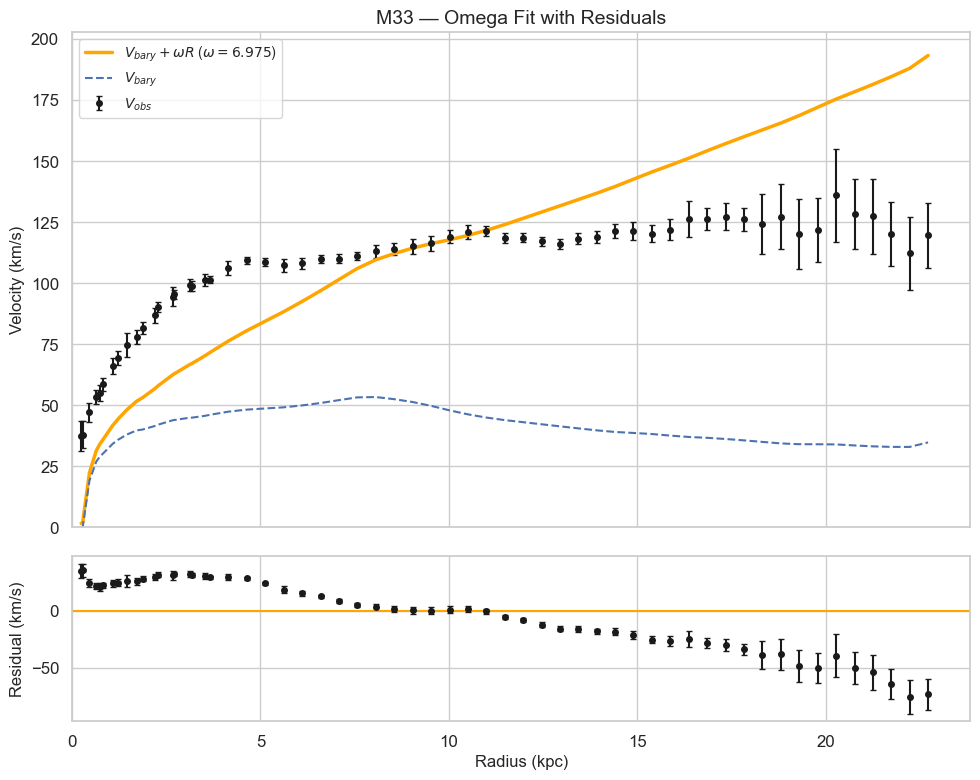

Residual statistics:
  Mean: -2.04 km/s
  Std:  30.99 km/s
  RMSE: 31.05 km/s


In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True,
                                gridspec_kw={'height_ratios': [3, 1]})

# Top: fit
ax1.errorbar(radius, df['v_obs'].values, yerr=df['v_err'].values,
             fmt='ko', markersize=4, capsize=2, label=r'$V_{obs}$')
ax1.plot(radius, result.v_model, 'orange', linewidth=2.5,
         label=rf'$V_{{bary}} + \omega R$ ($\omega={result.omega_value:.3f}$)')
ax1.plot(radius, v_bary, 'b--', linewidth=1.5, label=r'$V_{bary}$')
ax1.set_ylabel('Velocity (km/s)', fontsize=12)
ax1.legend(fontsize=10)
ax1.set_title('M33 — Omega Fit with Residuals', fontsize=14)
ax1.set_ylim(bottom=0)

# Bottom: residuals
ax2.errorbar(radius, result.residuals, yerr=df['v_err'].values,
             fmt='ko', markersize=4, capsize=2)
ax2.axhline(y=0, color='orange', linewidth=1.5)
ax2.set_xlabel('Radius (kpc)', fontsize=12)
ax2.set_ylabel('Residual (km/s)', fontsize=12)
ax2.set_xlim(left=0)

plt.tight_layout()
fig.savefig('../results/figures/M33_residuals.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Residual statistics:')
print(f'  Mean: {np.mean(result.residuals):.2f} km/s')
print(f'  Std:  {np.std(result.residuals):.2f} km/s')
print(f'  RMSE: {result.residuals_rmse:.2f} km/s')

## 9. Summary Tables & Export

Generate presentable summary tables and export all results to CSV for the team.
Results are saved to `results/tables/` for downstream analysis.

In [11]:
# --- Fit Summary Table ---
from pathlib import Path

tables_dir = Path('../results/tables')
tables_dir.mkdir(parents=True, exist_ok=True)

summary_df = result.to_summary_dataframe()
display(summary_df.style.set_caption("M33 Omega Fit Summary"))

summary_path = tables_dir / 'M33_fit_summary.csv'
summary_df.to_csv(summary_path, index=False)
print(f"Saved: {summary_path}")

,galaxy,omega_km_s_kpc,omega_err,chi2_reduced,rmse_km_s,n_points,converged,upsilon_disk,upsilon_bulge,method_version,flag_v_obs_lt_v_bary
0,M33,6.974863,0.041827,72.907215,31.053169,58,True,0.500000,0.700000,v1_fixed_ML,False


Saved: ..\results\tables\M33_fit_summary.csv


In [12]:
# --- Sensitivity Analysis Export ---
display(sens_df.round(4).style.set_caption("M33 Sensitivity: Omega vs Upsilon_disk"))

sens_path = tables_dir / 'M33_sensitivity.csv'
sens_df.to_csv(sens_path, index=False)
print(f"Saved: {sens_path}")

,upsilon_disk,omega,omega_err,chi2_r
0,0.300000,7.552100,0.041800,110.490800
1,0.350000,7.399300,0.041800,99.425900
2,0.400000,7.252700,0.041800,89.604100
3,0.450000,7.111400,0.041800,80.816600
4,0.500000,6.974900,0.041800,72.907200
5,0.550000,6.842600,0.041800,65.755300
6,0.600000,6.714200,0.041800,59.265400
7,0.650000,6.589400,0.041800,53.360500
8,0.700000,6.467800,0.041800,47.977500
9,0.750000,6.349100,0.041800,43.063800


Saved: ..\results\tables\M33_sensitivity.csv


In [13]:
# --- Radial Profile with Model ---
profile_df = result.to_radial_profile_dataframe(
    radius=radius,
    v_obs=df['v_obs'].values,
    v_err=df['v_err'].values,
    v_gas=df['v_gas'].values,
    v_disk=df['v_disk'].values,
    v_bulge=df['v_bulge'].values,
)
display(profile_df.head(10).style.set_caption("M33 Radial Profile (first 10 rows)"))

profile_path = tables_dir / 'M33_radial_profile.csv'
profile_df.to_csv(profile_path, index=False, float_format='%.4f')
print(f"Saved: {profile_path} ({len(profile_df)} rows)")

,radius_kpc,v_obs,v_err,v_gas,v_disk,v_bulge,v_bary,v_model,residual
0,0.240000,37.300000,6.200000,0.000000,0.000000,0.000000,0.000000,1.673967,35.626033
1,0.280000,37.900000,5.500000,0.000000,0.000000,0.000000,0.000000,1.952962,35.947038
2,0.460000,47.100000,3.900000,0.000000,27.053590,0.000000,19.129777,22.338214,24.761786
3,0.640000,53.500000,2.800000,2.231145,37.894227,0.000000,26.887994,31.351907,22.148093
4,0.730000,55.100000,3.300000,2.909610,40.625337,0.000000,28.873428,33.965078,21.134922
5,0.820000,58.500000,2.500000,3.580612,42.443850,0.000000,30.225172,35.944559,22.555441
6,1.080000,66.200000,3.300000,4.560130,48.002083,0.000000,34.247551,41.780403,24.419597
7,1.220000,69.400000,2.800000,3.797043,50.427262,0.000000,35.859056,44.368390,25.031610
8,1.450000,74.600000,5.000000,0.000000,53.709808,0.000000,37.978569,48.092121,26.507879
9,1.710000,77.900000,2.900000,0.000000,56.135976,0.000000,39.694129,51.621145,26.278855


Saved: ..\results\tables\M33_radial_profile.csv (58 rows)


In [14]:
# --- Validation Metrics ---
# Round-trip check: compare V_bary recomputed in this notebook against
# the V_bary computed during ingestion (stored as v_baryon_total in DB).
# These should match exactly since both use the same parameters.
# For a true independent Corbelli comparison, we would need Corbelli's
# published V_bary values as a separate reference dataset.
from src.physics import compute_validation_metrics

val_df = compute_validation_metrics(
    radius=radius,
    v_bary=v_bary,
    v_bary_reference=df['v_baryon_total'].values,
    min_radius=2.0,
    threshold_pct=5.0,
)

n_exceed = val_df['exceeds_threshold'].sum()
max_pct = val_df['pct_diff'].max()

print(f"Validation (R > 2 kpc): {len(val_df)} points evaluated")
print(f"  Max % difference: {max_pct:.2f}%")
print(f"  Points exceeding 5% threshold: {n_exceed}")

if n_exceed == 0:
    print("  PASS: All points within 5% tolerance")
else:
    print("  WARNING: Some points exceed 5% threshold — investigate")
    display(val_df[val_df['exceeds_threshold']])

val_path = tables_dir / 'M33_validation.csv'
val_df.to_csv(val_path, index=False, float_format='%.4f')
print(f"\nSaved: {val_path}")

Validation (R > 2 kpc): 47 points evaluated
  Max % difference: 0.00%
  Points exceeding 5% threshold: 0
  PASS: All points within 5% tolerance

Saved: ..\results\tables\M33_validation.csv


In [15]:
# --- Store M33 omega fit in database ---
# NOTE: Re-running this cell will insert a new row each time.
# Multiple runs are identifiable by the timestamp column.
from src.database import insert_omega_fit

fit_record = insert_omega_fit(session, result.to_dict())
print(f"Stored fit_id={fit_record.fit_id} for {fit_record.galaxy_id}")
print(f"  omega={fit_record.omega_value:.4f}, chi2_r={fit_record.reduced_chi_squared:.2f}")

2026-02-22 17:51:31 | INFO     | src.database | Stored omega fit for M33: omega=6.9749 +/- 0.0418 (chi2=4155.71)


Stored fit_id=122 for M33
  omega=6.9749, chi2_r=72.91


In [16]:
# --- Log session summary ---
from src.utils import setup_logger

log = setup_logger(
    'm33_calibration',
    log_file=True,
    clear_logs=True,
)

log.info("=" * 60)
log.info("M33 CALIBRATION — SESSION SUMMARY")
log.info("=" * 60)
log.info("Data source: Corbelli et al. (2014) Table 1")
log.info("Radial profiles: %d points (%.2f – %.2f kpc)", len(df), radius.min(), radius.max())
log.info("Upsilon_disk=%.2f, Upsilon_bulge=%.2f", UPSILON_DISK, UPSILON_BULGE)
log.info("---")
log.info("omega = %.4f +/- %.4f km/s/kpc", result.omega_value, result.omega_uncertainty)
log.info("chi2_reduced = %.2f", result.reduced_chi_squared)
log.info("RMSE = %.2f km/s", result.residuals_rmse)
log.info("Converged: %s", result.converged)
log.info("V_obs < V_bary flag: %s", result.flag_v_obs_lt_v_bary)
log.info("---")
log.info("Validation (R > 2 kpc): max pct_diff=%.2f%%, points exceeding 5%%: %d",
         max_pct, n_exceed)
log.info("Exported tables: M33_fit_summary.csv, M33_sensitivity.csv, M33_radial_profile.csv, M33_validation.csv")
log.info("Fit stored in database (fit_id=%d)", fit_record.fit_id)
log.info("=" * 60)
print("\nLog written to logs/m33_calibration.log")

2026-02-22 17:51:31 | INFO     | m33_calibration | ============================================================
2026-02-22 17:51:31 | INFO     | m33_calibration | M33 CALIBRATION — SESSION SUMMARY
2026-02-22 17:51:31 | INFO     | m33_calibration | ============================================================
2026-02-22 17:51:31 | INFO     | m33_calibration | Data source: Corbelli et al. (2014) Table 1
2026-02-22 17:51:31 | INFO     | m33_calibration | Radial profiles: 58 points (0.24 – 22.72 kpc)
2026-02-22 17:51:31 | INFO     | m33_calibration | Upsilon_disk=0.50, Upsilon_bulge=0.70
2026-02-22 17:51:31 | INFO     | m33_calibration | ---
2026-02-22 17:51:31 | INFO     | m33_calibration | omega = 6.9749 +/- 0.0418 km/s/kpc
2026-02-22 17:51:31 | INFO     | m33_calibration | chi2_reduced = 72.91
2026-02-22 17:51:31 | INFO     | m33_calibration | RMSE = 31.05 km/s
2026-02-22 17:51:31 | INFO     | m33_calibration | Converged: True
2026-02-22 17:51:31 | INFO     | m33_calibration | V_obs < V_


Log written to logs/m33_calibration.log


In [17]:
# --- Clean up ---
session.close()
print("Session closed. All exports complete.")

Session closed. All exports complete.
